### Imports & declarations

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras.models import *
from keras.layers import *

data_path_mini = '../data/raw/kaggle_mini_subsample'
data_path_train = '../data/raw/train'

RANDOM_STATE = 2020

### Mini dataset

Found 500 images belonging to 2 classes.


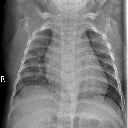

{'NORMAL': 0, 'PNEUMONIA': 1}


In [2]:
BATCH_SIZE = 250
TARGET_SIZE = [128, 128]
image_generator = ImageDataGenerator().flow_from_directory(data_path_mini, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

display(array_to_img(images[0]))
print(image_generator.class_indices)

In [4]:
x = images_scaled.reshape(250,128*128*3)

SHAPE = (x.shape[1],)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape = SHAPE))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
history = model.fit(x=x, y=labels, epochs=50)

Epoch 1/50
8/8 [==============================] - 0s 14ms/step - loss: 2.8369 - accuracy: 0.5640
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6801 - accuracy: 0.5560
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6599 - accuracy: 0.5960
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6540 - accuracy: 0.7440
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6581 - accuracy: 0.5480
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6107 - accuracy: 0.6160
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6586 - accuracy: 0.6520
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5272 - accuracy: 0.7640
Epoch 9/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6692 - accuracy: 0.6960
Epoch 10/50
8/8 [==============================] - 0s 14ms/step - loss: 0.5835 - accuracy: 0.7120
Epoch 11/50
8/8 [============

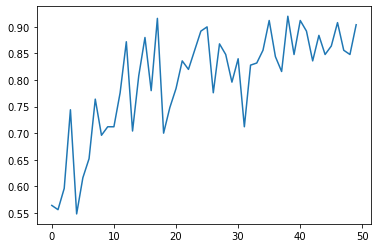

In [8]:
acc = history.history['accuracy']
plt.plot(range(len(acc)), acc);

### Full train dataset, no separate validation dataset used

In [9]:
BATCH_SIZE_TRAIN = 1341+3875
TARGET_SIZE = [128, 128]

generator_train = ImageDataGenerator().flow_from_directory(data_path_train,
                                                          batch_size=BATCH_SIZE_TRAIN,
                                                          target_size=TARGET_SIZE)

images_train, labels_train = next(generator_train)
images_train_scaled = images_train / 256

print(images_train_scaled.shape, labels_train.shape)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
(5216, 128, 128, 3) (5216, 2)
(16, 128, 128, 3) (16, 2)


In [10]:
s = images_train.shape
x = images_train_scaled.reshape(s[0], s[1]*s[2]*s[3])

SHAPE = (x.shape[1],)

print(x.shape, labels_train.shape, SHAPE)

(5216, 49152) (5216, 2) (49152,)


In [29]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape = SHAPE))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

In [30]:
history = model.fit(x=x, y=labels_train, epochs=100, validation_split=0.4, )

Epoch 1/100
98/98 [==============================] - 8s 78ms/step - loss: 0.7325 - accuracy: 0.7418 - mse: 0.1891 - val_loss: 0.5223 - val_accuracy: 0.8256 - val_mse: 0.1687
Epoch 2/100
98/98 [==============================] - 7s 69ms/step - loss: 0.4244 - accuracy: 0.7951 - mse: 0.1366 - val_loss: 0.5501 - val_accuracy: 0.6914 - val_mse: 0.1868
Epoch 3/100
98/98 [==============================] - 6s 61ms/step - loss: 0.3323 - accuracy: 0.8658 - mse: 0.1011 - val_loss: 0.4779 - val_accuracy: 0.7676 - val_mse: 0.1582
Epoch 4/100
98/98 [==============================] - 6s 56ms/step - loss: 0.2831 - accuracy: 0.8875 - mse: 0.0839 - val_loss: 0.1676 - val_accuracy: 0.9368 - val_mse: 0.0480
Epoch 5/100
98/98 [==============================] - 6s 60ms/step - loss: 0.2659 - accuracy: 0.8917 - mse: 0.0782 - val_loss: 0.1814 - val_accuracy: 0.9257 - val_mse: 0.0545
Epoch 6/100
98/98 [==============================] - 6s 61ms/step - loss: 0.2367 - accuracy: 0.9070 - mse: 0.0689 - val_loss: 0.21

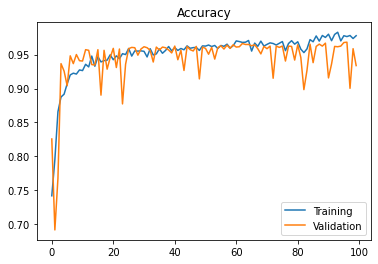

In [31]:
history.history.keys()

acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epoch_ct = range(len(acc_train))

plt.plot(epoch_ct, acc_train, label='Training')
plt.plot(epoch_ct, acc_val, label='Validation')
plt.title('Accuracy')
plt.legend();

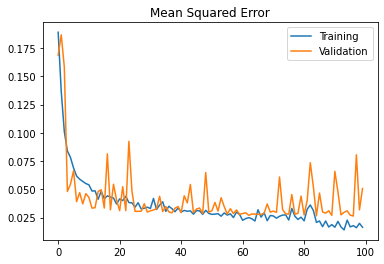

In [32]:
history.history.keys()

mse_train = history.history['mse']
mse_val = history.history['val_mse']
epoch_ct = range(len(mse_train))

plt.plot(epoch_ct, mse_train, label='Training')
plt.plot(epoch_ct, mse_val, label='Validation')
plt.title('Mean Squared Error')
plt.legend();

### Incorporate class weighting

In [40]:
x_train, x_val, y_train, y_val = train_test_split(images_train_scaled, labels_train, random_state=RANDOM_STATE, test_size = 0.25)

In [44]:
# Source for class weight calculations: 
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
y_train.sum(axis=0)

array([1038., 2874.], dtype=float32)

{'NORMAL': 0, 'PNEUMONIA': 1}

In [67]:
np.random.seed(RANDOM_STATE)

print(generator_train.class_indices)
ind_neg = y_train[:, 0]==1
ind_pos = y_train[:, 0]==0


neg_ct = ind_neg.sum()
pos_ct = ind_pos.sum()
print('Negative count:', neg_ct, ', Positive count:', pos_ct)

#np.random.choice()

{'NORMAL': 0, 'PNEUMONIA': 1}
Negative count: 1038 , Positive count: 2874
